# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"
data_file = "all_vars.csv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,6)[1:],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# def construct_models(): Used for quick testing
#     models = [
#         Model('Ridge',Ridge(),
#               parameters = {'alpha':np.logspace(1,4,2)},
#               importance_func=importance_from_coef
#         ),
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':[10],
#                 'learning_rate':np.logspace(-3,0,2),
#               }
#         ), 
#     ]
#     return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 638)
Treated data dimensions: (1295, 638)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [7]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

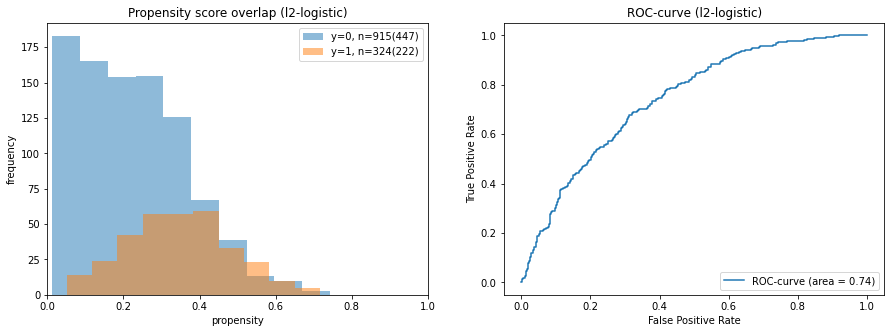

In [8]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [9]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
ahgyob,HF4 Year of Birth,0.060126,0.060126
aedq524,DV: ASCED 524 Certificate level I - Number of qualifications obtained since leaving school,0.054183,0.054183
aedq521,DV: ASCED 521 Certificate level II - Number of qualifications obtained since leaving school,0.053318,0.053318
afibcar,SCQ:C7d Alright to borrow for - Car,-0.051355,0.051355
ajbocct,DV: Tenure in current occupation (years),-0.043737,0.043737
aehtjbyr,D3a1 Years in paid work,-0.042881,0.042881
aedq511,DV: ASCED 511 Certificate level IV - Number of qualifications obtained since leaving school,0.042719,0.042719
aedqenr,C6 Ever enrolled in a course of study to obtain a qualification,-0.042421,0.042421
ahgage1,DV: Age last birthday at June 30 2001 - person 01,-0.041280,0.041280
aioinflu,Z2 Influence respondent answers,-0.040442,0.040442


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [10]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=10,
    load_from_cache=True
)

### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,33.61,16.28,0.21,0.06,0.14,0.07,"-688,463.59","168,415.73","-959,614.04","312,474.30"
lasso,9.01,14.42,0.21,0.07,0.22,0.11,"-680,970.92","166,558.24","-874,276.37","325,169.23"
gbr,38.64,17.33,0.22,0.13,0.16,0.11,"-680,899.29","217,370.58","-949,312.04","358,626.75"


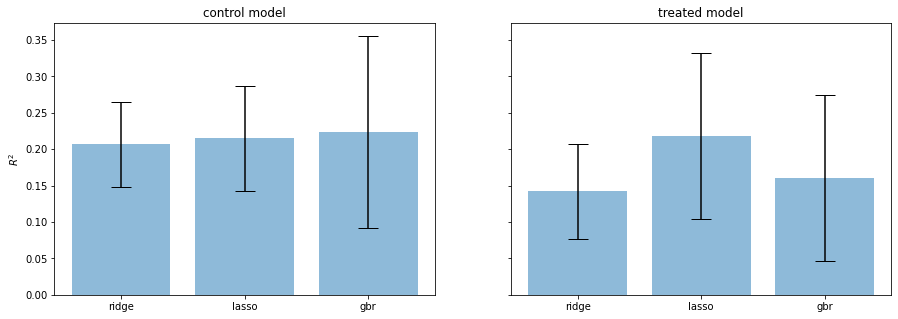

In [11]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [12]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
awscei,73.538499,10.555661,-4.745686,20.187288,-75.911342,17.085845,-71.165656,11.605222
ahgyob,41.868019,2.760484,-4.353201,6.417512,39.691419,5.256187,44.044619,2.864486
ahiwscei,39.571515,4.508290,15.891232,11.473520,-31.625899,8.322389,-47.517131,6.099839
aehtjbyr,37.827870,1.810920,3.358820,5.444930,-36.148461,4.117050,-39.507280,2.105325
awscmga,33.060498,5.140938,14.313323,11.199875,-25.903836,9.232627,-40.217160,5.507784
ahhold,31.438474,2.286241,4.657750,4.094150,-29.109599,3.882257,-33.767349,1.939823
ahgage1,27.773231,2.236591,-4.234347,4.333662,-29.890405,4.083259,-25.656058,1.649845
aicexpct,23.565614,2.013361,-17.778994,3.684328,14.676117,2.369375,32.455111,3.046383
ahgage2,22.257299,1.251610,9.489856,1.992637,-17.512371,1.560766,-27.002227,1.637793


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
ahgyob,269.939499,16.291120,107.145142,33.867765,323.512070,30.507997,216.366928,13.174826
awscei,268.903307,23.560826,-89.638332,62.490501,-313.722473,47.356583,-224.084141,28.637572
aicexpct,31.599051,5.224830,-60.399170,9.402615,1.399466,3.298609,61.798636,9.376644
ajbmocc1,30.532622,6.432577,-61.065243,12.865154,-61.065243,12.865154,0.000000,0.000000
abnage,28.974678,2.297707,57.949355,4.595415,0.000000,0.000000,-57.949355,4.595415
arcage1,28.930905,6.386966,-54.166185,13.259030,-56.013997,12.846441,-1.847812,2.111056
ahhold,28.637757,8.308590,-6.230111,15.527007,-31.752812,10.152264,-25.522702,12.471601
aoifdiva,28.233707,15.721221,-56.467414,31.442442,-56.467414,31.442442,0.000000,0.000000
ahiwsfei,27.550183,9.290265,55.100365,18.580530,55.100365,18.580530,0.000000,0.000000


### Compare against OLS on basic variables

In [13]:
basic = pd.read_csv("basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
if log_outcome:
    basic[outcome] = np.log(basic[outcome]+basic[outcome].min())
    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=10,
    load_from_cache=True)

Dropped 592 rows missing treatment or outcome.


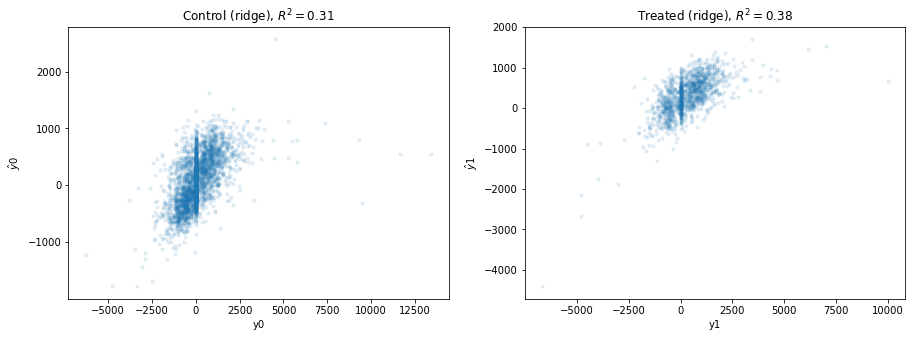

In [14]:
y0a = results['ridge'][0]['estimator'][1].predict(X0)
y1a = results['ridge'][1]['estimator'][1].predict(X1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0a,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

ax[1].scatter(y1, y1a,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)

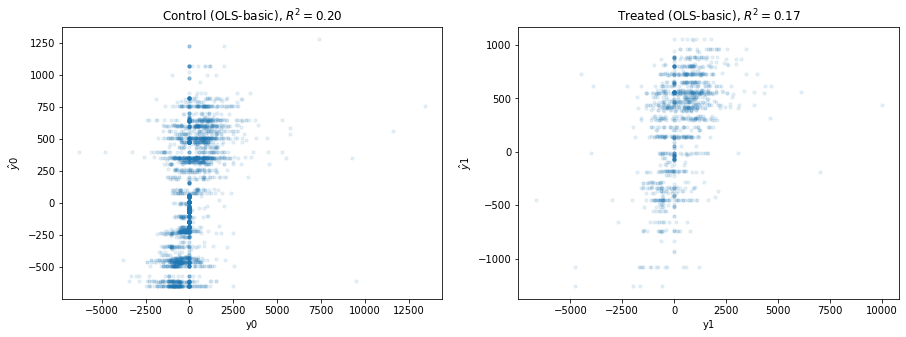

In [15]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [16]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_

bootstrap_results = bootstrapped_cross_val(
    construct_models,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=5,
    load_from_cache=True,
    samples=50
)

####  Average treatment effects

In [17]:
from direct_regression import compute_ate
compute_ate(bootstrap_results,X)

,ACE,ACE_std
ridge,60.805724,32.327294
lasso,29.961487,33.191333
gbr,40.362782,30.378908


#### Distribution of hyper-parameters

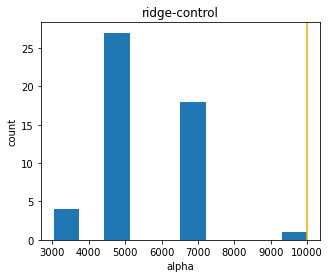

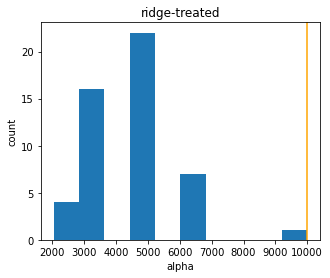

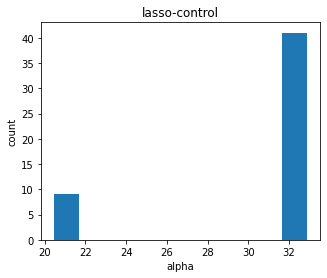

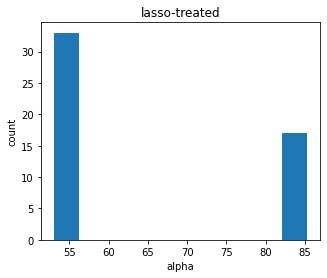

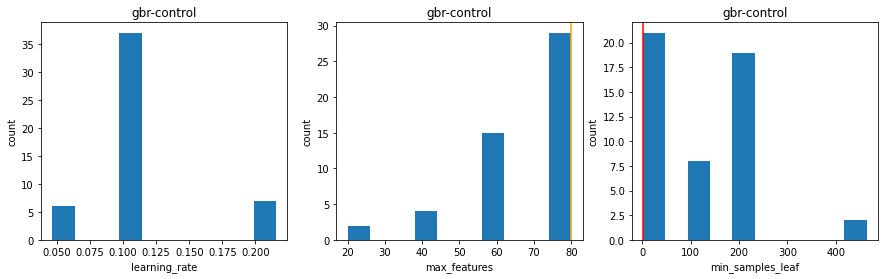

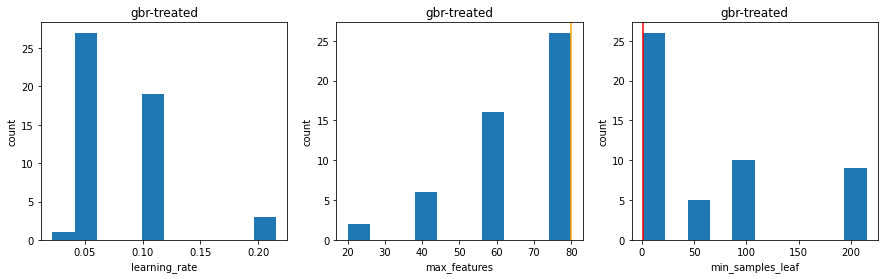

In [18]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")